# Template for importing and processing the data

The data file contains the raw output from the scanner (Columbus is used as an example). It is imported and processed in a table containing the treatment annotations (Protocol 2, steps 1 and 2). Basic quality control is performed (Protocol 2, step 3). Finally the annotated data is normalized using the GR method and sensitvity metrics are calculated (Protocol 3, steps 1 and 2).

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import datarail.utils.plate_fcts as pltfct
import datarail.import_modules.columbus_import_functions as CoImp
import datarail.data_processing.drug_response.treatment_annotation as TrtAnnot
import gr50
import gr50.plot

import matplotlib.pyplot as plt
%matplotlib inline

## Data import and annotation (protocol 2, steps 1 and 2)

In [2]:
# load the synthetic data (Columbus output)
df=CoImp.Columbus_processing('../tests/drug_response_data/OUTPUT/Example1_Columbus_output.tsv',
                              (('Hoechst_pos', 'cell_count__total'),
                               ('LDR_pos_Hoechst_neg', 'corpse_count'),
                               ('Hoechst_LDR_pos', 'cell_count__dead')),
                              'cell_count__total - cell_count__dead')

# annotate the data
df_annotated = TrtAnnot.add_treatments(
    TrtAnnot.add_plate_info(df,
        pd.read_csv('../tests/drug_response_data/OUTPUT/Example1_plate_info.tsv', sep='\t')),
    '../tests/drug_response_data/OUTPUT/')

df_annotated.to_csv('OUTPUT/AnnotatedData_Example1.tsv', sep='\t', index=False)


Default number of fields: 6 ; 505 wells with missing field(s)
Concentrations rounded in the log domain


## Quality control (protocol 2, step 3)

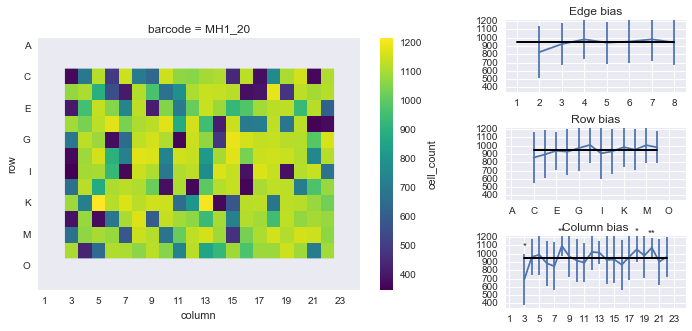

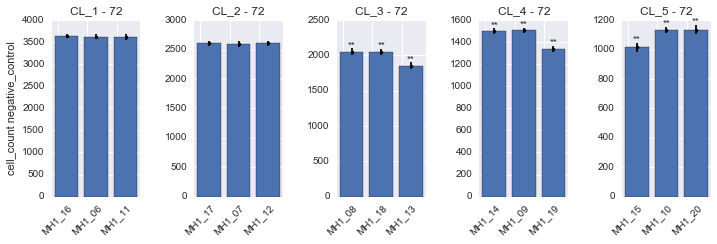

In [3]:
import datarail.data_processing.drug_response.qc_plate as qcfct

# use the raw data to perform the plate QC
qcfct.Plate_bias(pltfct.dfplate2xr(df), filename='OUTPUT/QC_report_Example1.pdf')
# use the annotated data to perform QC based on the negative controls
qcfct.Negative_control_bias(df_annotated)

## Calculate the GR values (protocol 3, step 1)

In [4]:
# first calculate the GR values for each replicate then merge them
df_mean = TrtAnnot.average_replicates(
    gr50.compute_gr(
        gr50.assign_ctrls(df_annotated, ['cell_line'])))

df_gr = df_mean.drop(['cell_count__dead','corpse_count','role','cell_count__total'],axis=1)
df_gr.to_csv('OUTPUT/GRvalues_Example1.tsv', sep='\t', index=False)
df_gr.head()

Columns to average: "corpse_count" "cell_count__total" "cell_count" "cell_count__dead" "cell_count__ctrl" "GRvalue" "cell_count__time0"
Columns added as annotations: "date"

-->Following columns are discarded:
 "treatment_file" "well" "barcode" 
	(set as key if necessary)


,cell_line,treatment_duration,concentration,agent,date,cell_count,cell_count__ctrl,GRvalue,cell_count__time0
0,CL_1,72.0,0.001,D_1,2016-06-06 12:34:56,3583.444444,3627.85,0.991393,491.525
1,CL_1,72.0,0.001,D_2,2016-06-06 12:34:56,3612.000000,3627.85,0.996945,491.525
2,CL_1,72.0,0.001,D_3,2016-06-06 12:34:56,2735.000000,3627.85,0.813313,491.525
3,CL_1,72.0,0.001,D_4,2016-06-06 12:34:56,3639.888889,3627.85,1.002234,491.525
4,CL_1,72.0,0.001,D_5,2016-06-06 12:34:56,3630.555556,3627.85,1.000376,491.525


## Evaluate the GR metrics and plot the dose-response curves (protocol 3, step 2)

                 date cell_line agent  treatment_duration      GR50     GRmax  \
0 2016-06-06 12:34:56      CL_1   D_1                72.0  0.126677 -0.173488   
1 2016-06-06 12:34:56      CL_1   D_2                72.0  0.311289 -0.004219   
2 2016-06-06 12:34:56      CL_1   D_3                72.0  0.690251  0.401416   
3 2016-06-06 12:34:56      CL_1   D_4                72.0  3.703113 -0.096859   
4 2016-06-06 12:34:56      CL_1   D_5                72.0  0.668006 -0.094478   

     GR_AOC     GEC50     GRinf      h_GR        r2          pval  
0  0.521884  0.180590 -0.195387  0.930270  0.999900  9.992007e-15  
1  0.375490  0.311573 -0.001281  2.805116  0.999949  8.881784e-16  
2  0.403562  0.039185  0.276279  0.280334  0.999646  8.330003e-13  
3  0.117477  4.170068 -0.194446  2.766167  0.999968  2.220446e-16  
4  0.312724  0.739848 -0.107022  1.898776  0.999925  3.552714e-15  


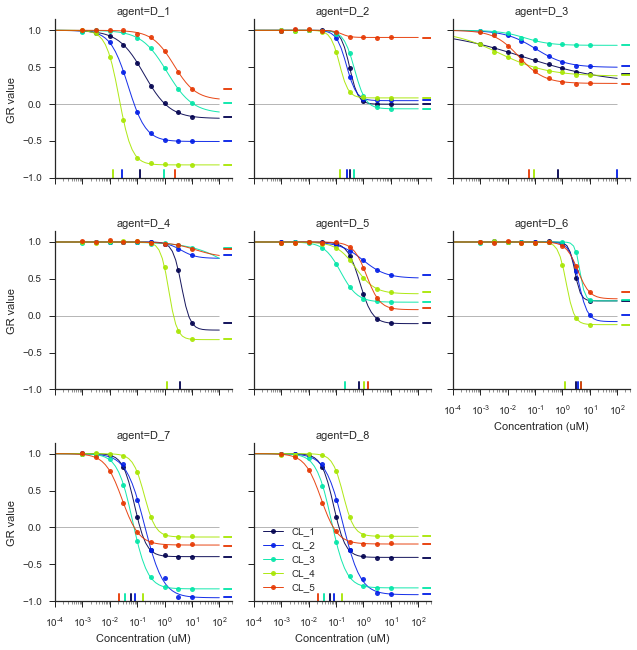

In [5]:
df_grmetrics = gr50.gr_metrics(df_gr)
df_grmetrics.to_csv('OUTPUT/GRmetrics_Example1.tsv', sep='\t', index=False)
print df_grmetrics.head()
fig = gr50.plot.plot_curves(df_grmetrics, df_gr, colorvar='cell_line', colvar='agent')
fig.savefig('OUTPUT/GRcurves_Example1.pdf')